In [3]:
import math
import random
import matplotlib.pyplot as plt

In [4]:
def random_vector(minmax):
    vector = list()
    for i in range(len(minmax)):
        rand = minmax[i][0] + ((minmax[i][1] - minmax[i][0]) * random.random())
        vector.append(rand)
    return vector

In [5]:
def initialize_weights(num_weights):
    minmax = list()
    for i in range(num_weights):
        minmax.append([0, 0.5])
    return random_vector(minmax)

## Log-Sigmoid Activation
Activate

An activation value is calculated by summing each input value times it's corresponding weight (plus a bias value)
Transfer

Runs the activation value through the log-sigmoid function to determine the neuron's output 
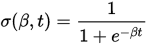
Transfer Derivative

Returns the derivative of the log-sigmoid function which is used in error calculation during back-propagation 
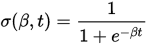

In [6]:
def activate(weights, vector, bias=1.0):
    # initialize sum with output's weight * bias
    _sum = weights[-1] * bias
    for i in range(len(vector)):
        _sum += weights[i] * vector[i]
    return _sum

In [7]:
def transfer(activation):
    return 1.0 / (1.0 + math.exp(-activation))

In [8]:
def transfer_derivative(output):
    return output * (1.0 - output)

## Forward Porpagation
Inputs

    network: Neural Network
    vector: The problem set (does not include the solution)

Process

Forward propagation passes the vector (problem set) through each layer of the network and returns the overall output

    Hidden Layers
        Each Neuron "activates" the vector
        The activation's value is then evaluated to produce an output

    Output Layer
        Collects the output from every neuron in the network
        Neuron "activates" the collected outputs
        Produces an overall output for the network



In [9]:
def forward_propagate(network, vector):
    for i in range(len(network)):
        layer = network[i]
        _input = None
        
        # Hidden Layers
        if (i != (len(network) - 1)):
            _input = vector
            
        # Output Layer
        else:
            hidden_layer_outputs = list()
            previous_layer = network[i - 1]
            for k in range(len(previous_layer)):
                hidden_layer_outputs.append(previous_layer[k]["output"])
            _input = hidden_layer_outputs
        
        # Activation and Output
        for neuron in layer:
            neuron["activation"] = activate(neuron["weights"], _input)
            neuron["output"] = transfer(neuron["activation"])
            
    # Return the overall output
    return network[-1][0]["output"] # Assumes one node for output layer

## Backward Propagation

Backward propagation calculates the level error in each neuron's output
Inputs

    network: Neural Network
    expected_output: Known solution to the problem

Process

    Output Layer
        Calculate error for the network based on the known solution
        Set "delta" to the error times the derivative of the log-sigmoid output
    Hidden Layers
        Looks at each neuron in the layer
            Calculates the error attributed to that neuron based on how it effected the next layer of the network
            Each neuron in the next layer's corresponding wheight and "delta" add to the error value
            Set "delta" to the error times the derivative of the log-sigmoid output



In [10]:
def backward_propagate_error(network, expected_output):
    for i in range(len(network)):
        index = len(network) - 1 - i
        layer = network[index]
        
        # Output Layer
        if (index == (len(network) - 1)):
            neuron = layer[0] # assume one node in output layer
            error = (expected_output - neuron["output"])
            neuron["delta"] = error * transfer_derivative(neuron["output"])
            
        # Hidden Layers
        else:
            next_layer = network[index + 1]
            for j in range(len(layer)):
                err_sum = 0.0
                neuron = layer[j]
                for next_neuron in next_layer:
                    err_sum += next_neuron["weights"][j] * next_neuron["delta"]
                neuron["delta"] = err_sum * transfer_derivative(neuron["output"])

## Adjusting Weights

In [11]:
def calculate_error_derivatives_for_weights(network, vector):
    for i in range(len(network)):
        layer = network[i]
        _input = None
        
        # Hidden Layers
        if (i != (len(network) - 1)):
            _input = vector
            
        # Output Layer
        else:
            hidden_layer_outputs = list()
            previous_layer = network[i - 1]
            for k in range(len(previous_layer)):
                hidden_layer_outputs.append(previous_layer[k]["output"])
            _input = hidden_layer_outputs
            
        # Calculate error derivative for weights
        for neuron in layer:
            signal = None
            for k in range(len(_input)):
                signal = _input[k]
                neuron["deriv"][k] += neuron["delta"] * signal
            # Bias's weight
            neuron["deriv"][-1] += neuron["delta"] * 1.0

In [12]:
def update_weights(network, learning_rate, mom=0.8):
    for layer in network:
        for neuron in layer:
            for i in range(len(neuron["weights"])):
                delta = (learning_rate * neuron["deriv"][i]) + (neuron["last_delta"][i] * mom)
                neuron["weights"][i] += delta
                neuron["last_delta"][i] = delta
                neuron["deriv"][i] = 0.0

## Supervised Learning

In [13]:
def train_network(network, training_data, num_inputs, iterations, learning_rate, benchmark):
    correct = 0
    for epoch in range(iterations):
        for pattern in training_data:
            vector = list()
            for k in range(num_inputs):
                vector.append(float(pattern[k]))
            expected = pattern[-1]
            output = forward_propagate(network, vector)
            if (round(output) == expected):
                correct += 1
            backward_propagate_error(network, expected)
            calculate_error_derivatives_for_weights(network, vector)
        update_weights(network, learning_rate)
        
        # Collect data throught iterations
        if (((epoch + 1) % benchmark) == 0):
            print("> epoch = " + str(epoch+1) + ", Correct = " + str(correct / (benchmark * len(training_data))))
            correct = 0

## Testing

In [14]:
def test_network(network, domain, num_inputs):
    correct = 0
    for pattern in domain:
        input_vector = list()
        for i in range(num_inputs):
            input_vector.append(float(pattern[i]))
        output = forward_propagate(network, input_vector)
        if (round(output) == pattern[-1]):
            correct += 1
    print("Finished test with a score of " + str(correct / len(domain)))
    return correct

## Network Creation

In [15]:
def create_neuron(num_inputs):
    neuron = {}
    neuron["weights"] = initialize_weights(num_inputs + 1)
    neuron["last_delta"] = [0.0] * (num_inputs + 1)
    neuron["deriv"] = [0.0] * (num_inputs + 1)
    return neuron

In [16]:
def build_network(layer_pattern, num_inputs):
    network = []
    
    #Build each layer of the network
    for i in range(len(layer_pattern)):
        num_nodes = layer_pattern[i]
        layer = []
        if (i == 0):
            for j in range(num_nodes):
                layer.append(create_neuron(num_inputs))
        else:
            for j in range(num_nodes):
                layer.append(create_neuron(len(network[i-1])))
        network.append(layer)
    
    # Create Output Node
    network.append([create_neuron(len(network[-1]))])
    
    return network

## Train and Testing a Network

In [17]:
def execute(network, training_data, num_inputs, iterations, learning_rate, benchmark):
    print("Topology: inputs = " + str(num_inputs) + "  layers = " + str(len(network)))
    train_network(network, training_data, num_inputs, iterations, learning_rate, benchmark)
    test_network(network, training_data, num_inputs)
    return network

## XOR Problem

In [18]:
if __name__ == "__main__":
    # problem configuration
    xor = [[0,0,0], [0,1,1], [1,0,1], [1,1,0]]
    inputs = 2
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 1000
    benchmark = 100
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, xor, inputs, iterations, learning_rate, benchmark)

Topology: inputs = 2  layers = 3
> epoch = 100, Correct = 0.49
> epoch = 200, Correct = 0.5
> epoch = 300, Correct = 0.575
> epoch = 400, Correct = 0.75
> epoch = 500, Correct = 0.75
> epoch = 600, Correct = 0.785
> epoch = 700, Correct = 1.0
> epoch = 800, Correct = 1.0
> epoch = 900, Correct = 1.0
> epoch = 1000, Correct = 1.0
Finished test with a score of 1.0


##  XOR Single-Layer

In [19]:
if __name__ == "__main__":
    # problem configuration
    xor = [[0,0,0], [0,1,1], [1,0,1], [1,1,0]]
    inputs = 2
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [1]
    iterations = 1000
    benchmark = 100
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, xor, inputs, iterations, learning_rate, benchmark)

Topology: inputs = 2  layers = 2
> epoch = 100, Correct = 0.5075
> epoch = 200, Correct = 0.5
> epoch = 300, Correct = 0.5
> epoch = 400, Correct = 0.6225
> epoch = 500, Correct = 0.75
> epoch = 600, Correct = 0.75
> epoch = 700, Correct = 0.75
> epoch = 800, Correct = 0.75
> epoch = 900, Correct = 0.75
> epoch = 1000, Correct = 0.75
Finished test with a score of 0.75


##  Basic Truth Table

In [21]:
if __name__ == "__main__":
    # problem configuration
    orAndNot = [[1,1,1,0],[1,1,0,1],[1,0,1,0],[0,1,1,0],[1,0,0,1],[0,1,0,1],[0,0,1,0],[0,0,0,0]]
    inputs = 3
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 100
    benchmark = 10
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, orAndNot, inputs, iterations, learning_rate, benchmark)

Topology: inputs = 3  layers = 3
> epoch = 10, Correct = 0.575
> epoch = 20, Correct = 0.625
> epoch = 30, Correct = 0.625
> epoch = 40, Correct = 0.625
> epoch = 50, Correct = 0.625
> epoch = 60, Correct = 0.7125
> epoch = 70, Correct = 0.75
> epoch = 80, Correct = 0.9625
> epoch = 90, Correct = 1.0
> epoch = 100, Correct = 1.0
Finished test with a score of 1.0


## Training on Partial Data

In [22]:
if __name__ == "__main__":
    # problem configuration
    orAndNot = [[1,1,1,0],[1,1,0,1],[1,0,1,0],[0,1,1,0],[1,0,0,1]] # [0,1,0,1],[0,0,1,0],[0,0,0,0]
    inputs = 3
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 100
    benchmark = 10
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, orAndNot, inputs, iterations, learning_rate, benchmark)
    
    # test on data it was not trained on
    test_set = [[0,1,0,1],[0,0,1,0],[0,0,0,0]]
    test_network(network, test_set, inputs)

Topology: inputs = 3  layers = 3
> epoch = 10, Correct = 0.54
> epoch = 20, Correct = 0.6
> epoch = 30, Correct = 0.6
> epoch = 40, Correct = 0.6
> epoch = 50, Correct = 0.78
> epoch = 60, Correct = 1.0
> epoch = 70, Correct = 1.0
> epoch = 80, Correct = 1.0
> epoch = 90, Correct = 1.0
> epoch = 100, Correct = 1.0
Finished test with a score of 1.0
Finished test with a score of 0.6666666666666666


## XOR Partial

In [23]:
if __name__ == "__main__":
    # problem configuration
    xor = [[0,0,0], [0,1,1], [1,0,1]] # [1,1,0]
    inputs = 2
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 1000
    benchmark = 100
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, xor, inputs, iterations, learning_rate, benchmark)
    
     # test on data it was not trained on
    test_set = [[1,1,0]]
    test_network(network, test_set, inputs)

Topology: inputs = 2  layers = 3
> epoch = 100, Correct = 0.76
> epoch = 200, Correct = 1.0
> epoch = 300, Correct = 1.0
> epoch = 400, Correct = 1.0
> epoch = 500, Correct = 1.0
> epoch = 600, Correct = 1.0
> epoch = 700, Correct = 1.0
> epoch = 800, Correct = 1.0
> epoch = 900, Correct = 1.0
> epoch = 1000, Correct = 1.0
Finished test with a score of 1.0
Finished test with a score of 0.0


## XOR Complex

In [24]:
if __name__ == "__main__":
    # problem configuration
    xorComplex = [[1,1,1,1],[1,1,0,0],[1,0,1,1],[0,1,1,1],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
    inputs = 3
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 2000
    benchmark = 200
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, xorComplex, inputs, iterations, learning_rate, benchmark)

Topology: inputs = 3  layers = 3
> epoch = 200, Correct = 0.775625
> epoch = 400, Correct = 0.875
> epoch = 600, Correct = 0.875
> epoch = 800, Correct = 0.875
> epoch = 1000, Correct = 0.875
> epoch = 1200, Correct = 0.875
> epoch = 1400, Correct = 0.875
> epoch = 1600, Correct = 0.875
> epoch = 1800, Correct = 0.875
> epoch = 2000, Correct = 0.875
Finished test with a score of 0.875


## XOR Complex 2

In [25]:
if __name__ == "__main__":
    # problem configuration
    xorComplex2 = [[1,1,1,1],[1,1,0,0],[1,0,1,1],[0,1,1,1],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
    inputs = 3
    
    # algorithm configuration
    learning_rate = 0.3
    hidden_layer_pattern = [2, 2]
    iterations = 1000
    benchmark = 100
    
    # execute the algorithm
    network = build_network(hidden_layer_pattern, inputs)
    execute(network, xorComplex2, inputs, iterations, learning_rate, benchmark)

Topology: inputs = 3  layers = 3
> epoch = 100, Correct = 0.76375
> epoch = 200, Correct = 0.875
> epoch = 300, Correct = 0.99
> epoch = 400, Correct = 1.0
> epoch = 500, Correct = 1.0
> epoch = 600, Correct = 1.0
> epoch = 700, Correct = 1.0
> epoch = 800, Correct = 1.0
> epoch = 900, Correct = 1.0
> epoch = 1000, Correct = 1.0
Finished test with a score of 1.0


## SUMBER : https://github.com/KeithCissell/Back-Propagation/tree/master/.ipynb_checkpoints